# 음식배달의 시간 예측하기 (A-김현우)

## 1. 큰 그림 보기

### 풀어야 할 문제 : 레스토랑들의 데이터를 사용하여 음식배달에 걸리는 시간 모델을 만드는 것
- 예측된 배달시간보다 실제 배달시간이 더 걸린 경우(under-prediction)가 반대의 경우(over-prediction)보다 **두 배**로 사용자의 경험에 안 좋은 영향을 준다고 알려져 있습니다.
- 가능한 실제 배달시간과 가까운 값을 예측하되 동시에 under-prediction을 최소화하는 것이 좋은 예측모델입니다.
- 테스트 데이터에 대한 평가지표들  
Mean Absolute Error (MAE)  
Under-prediction의 비율 (under-prediction 개수 / 테스트 데이터의 샘플수)

### 문제 정의
- 지도학습(supervised learning) 
- 회귀문제(regresssion)
- 배치학습(batch learning)

### 성능측정지표(performance measure) 선택

#### 1. 평균절대 오차 MAE (Mean Absolute Error)

$\mathrm{MAE}(\mathbf{X}, h) = \frac{1}{m}\sum_{i=1}^{m}\vert(h\left(\mathbf{x}^{(i)}\right)-y^{(i)}\vert$

- $m$: 데이터셋에 있는 샘플 수
- $\mathbf{x}^{(i)}$: $i$번째 샘플의 전체 특성값의 벡터(vector)
- $y^{(i)}$: $i$번째 샘플의 label(해당 샘플의 기대 출력값)
\begin{align*}
\mathbf{x}^{(1)} = \begin{bmatrix}
           -118.29 \\
           33.91 \\
           1,416 \\
           38,372
\end{bmatrix}
\end{align*}

$$y^{(1)} = 156,400$$
- $\mathbf{X}$: 데이터셋 모든 샘플의 모든 특성값(features)을 포함하는 행렬(matrix)  

\begin{align*}
\mathbf{X} = \begin{bmatrix}
           \left(\mathbf{x}^{(1)}\right)^T \\
           \left(\mathbf{x}^{(2)}\right)^T \\
           \vdots \\
           \left(\mathbf{x}^{(2000)}\right)^T
           \end{bmatrix}
           = \begin{bmatrix}
           -188.29 & 33.91 & 1,416 & 38,372 \\
           \vdots & \vdots & \vdots & \vdots
           \end{bmatrix}
\end{align*}

- $h$: 예측함수(prediction function). 하나의 샘플 $\mathbf{x}^{(i)}$에 대해 예측값 $\hat{y}^{(i)} = h\left(\mathbf{x}^{(i)}\right)$를 출력함.
- $\mathrm{MAE}(\mathbf{X}, h)$: 모델 $h$가 얼마나 좋은지 평가하는 지표, 또는 비용함수(cost function)
>- $\mathrm{MAE}$는 실제 값과 예측 값의 차이(Error)를 절대값으로 변환해 평균화 
```python
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)
```


- 에러에 절대값을 취하기 때문에 에러의 크기 그대로 반영된다.  
그러므로 예측 결과물의 **에러가 10이 나온 것이 5로 나온 것보다 2배가 나쁜 도메인**에서 쓰기 적합한 산식이다.
- 에러에 따른 손실이 선형적으로 올라갈 때 적합하다.
- 이상치가 많을 때

참고 : https://mizykk.tistory.com/102

#### 2. Under-prediction의 비율 
under-prediction 개수 / 테스트 데이터의 샘플수

-----

## 2. 셋팅 및 데이터 가져오기

In [1]:
import os
import pandas as pd

REST_PATH = os.path.join("datasets", "restaurant")

def load_restaurant_data(rest_path=REST_PATH):
    csv_path = os.path.join(rest_path, "predict_delivery_time.csv")
    return pd.read_csv(csv_path)

rest = load_restaurant_data() # csv -> dp 데이터 가져오기

-----

## 3. 데이터로부터 통찰을 얻기 위해 탐색과 시각화

### 데이터 구조 톺아보기

In [2]:
rest.head()

,Restaurant,Location,Cuisines,AverageCost,MinimumOrder,Rating,Votes,Reviews,DeliveryTime
0,ID6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12.0,4.0,30
1,ID2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11.0,4.0,30
2,ID1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99.0,30.0,65
3,ID5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176.0,95.0,30
4,ID6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521.0,235.0,65


Restaurant: A unique ID that represents a restaurant.  
Location: The location of the restaurant.  
Cuisines: The cuisines offered by the restaurant.  
Average_Cost: The average cost for one person/order.  
Minimum_Order: The minimum order amount.  
Rating: Customer rating for the restaurant.  
Votes: The total number of customer votes for the restaurant.  
Reviews: The number of customer reviews for the restaurant.  
Delivery_Time: The order delivery time of the restaurant. (Target Classes)   

In [3]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Restaurant    11094 non-null  object 
 1   Location      11094 non-null  object 
 2   Cuisines      11094 non-null  object 
 3   AverageCost   11094 non-null  object 
 4   MinimumOrder  11094 non-null  int64  
 5   Rating        9903 non-null   object 
 6   Votes         9020 non-null   float64
 7   Reviews       8782 non-null   float64
 8   DeliveryTime  11094 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 780.2+ KB


- Restaurant, Location, Cuisines : 범주형 데이터  
- Rating, AverageCost : 값은 숫자인데 object타입으로 되어있다.
- DeliveryTime에 결측치(NaN)는 없다.

In [4]:
rest['Rating'].value_counts()

3.7                   869
3.6                   846
3.5                   818
3.8                   800
NEW                   758
3.9                   749
3.4                   718
3.3                   675
4.0                   614
3.2                   511
4.1                   459
3.1                   411
3.0                   302
4.2                   272
4.3                   247
2.9                   199
2.8                   157
4.4                   142
4.5                    78
2.7                    76
2.6                    42
4.6                    41
4.7                    36
2.5                    27
4.8                    13
2.4                    13
Opening Soon           12
4.9                     8
2.3                     6
Temporarily Closed      2
2.2                     1
2.1                     1
Name: Rating, dtype: int64

In [5]:
rest['AverageCost'].value_counts()

200      3241
100      2557
150      2462
250       881
300       537
350       283
400       282
50        265
600       154
500       101
450        63
550        60
650        55
800        44
750        38
900        15
700        15
1,000      12
850        12
1,200       8
950         4
1,100       1
1,400       1
for         1
1,150       1
2,050       1
Name: AverageCost, dtype: int64

In [6]:
#rest[rest['Restaurant'].duplicated()]
rest[rest['Restaurant'] == 'ID4922']

,Restaurant,Location,Cuisines,AverageCost,MinimumOrder,Rating,Votes,Reviews,DeliveryTime
7074,ID4922,Mumbai Central,"Fast Food, Lebanese",150,50,NaN,NaN,NaN,30
8399,ID4922,Mumbai Central,"Chinese, Fast Food, Rolls",150,50,4.0,168.0,72.0,30
9903,ID4922,"Dockyard Road, Mumbai CST Area","Chinese, Fast Food, Rolls",150,50,4.0,168.0,72.0,30
10346,ID4922,"Mico Layout, Stage 2, BTM Layout,Bangalore","Mughlai, North Indian, Chinese, Momos",200,50,3.3,291.0,56.0,45
10424,ID4922,"Sandhurst Road, Mumbai CST Area","Chinese, Fast Food, Rolls",150,50,4.0,168.0,72.0,30


Restaurant의 ID가 중복값이 존재한다.

In [7]:
rest.describe() # 숫자형 데이터 정보

,MinimumOrder,Votes,Reviews,DeliveryTime
count,11094.000000,9020.000000,8782.000000,11094.000000
mean,53.344511,244.544457,123.247893,37.056066
std,18.551245,555.094733,321.025216,12.447496
min,0.000000,3.000000,1.000000,10.000000
25%,50.000000,19.000000,7.000000,30.000000
50%,50.000000,63.000000,26.000000,30.000000
75%,50.000000,216.000000,91.000000,45.000000
max,500.000000,9054.000000,6504.000000,120.000000


히스토그램으로 분석해보기

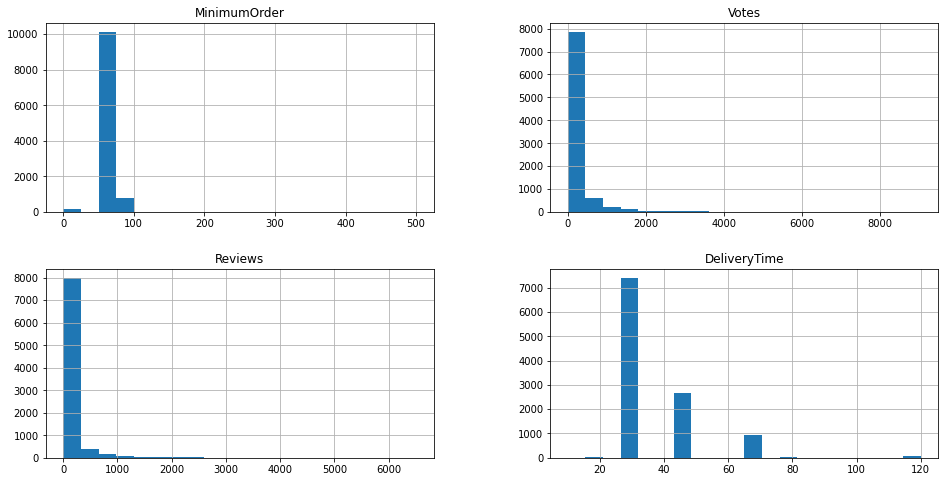

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

rest.hist(bins=20,figsize=(16,8))
plt.show()

### 데이터셋 분리하기 (훈련용, 테스트용)

**Scikit-Learn에서 기본적으로 제공되는 데이터분할 함수**

In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(rest, test_size=0.2, random_state=42)
len(train_set), len(test_set)

(8875, 2219)

### 데이터 이해를 위한 탐색과 시각화

**상관관계 관찰하기**

In [10]:
# 데이터 복사본 만들기 (훈련데이터를 손상시키지 않기 위해)
rest = train_set.copy()

<AxesSubplot:>

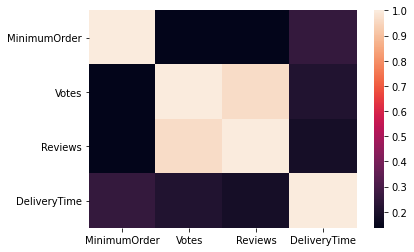

In [11]:
import seaborn as sns

corr_matrix = rest.corr()
sns.heatmap(corr_matrix)

In [12]:
corr_matrix['DeliveryTime'].sort_values(ascending=False)

DeliveryTime    1.000000
MinimumOrder    0.257467
Votes           0.211054
Reviews         0.185067
Name: DeliveryTime, dtype: float64

#### AverageCost, Rating 수치형으로 변환하기
문자열이 들어가있는 값에는 NaN 반환

In [13]:
rest['Rating'] = rest['Rating'].apply(pd.to_numeric, errors = 'coerce')
rest['AverageCost'] =  rest['AverageCost'].apply(pd.to_numeric, errors = 'coerce')

<AxesSubplot:>

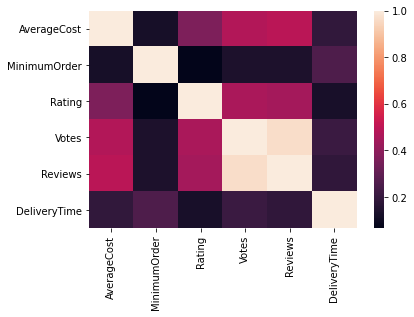

In [14]:
corr_matrix = rest.corr()
sns.heatmap(corr_matrix)

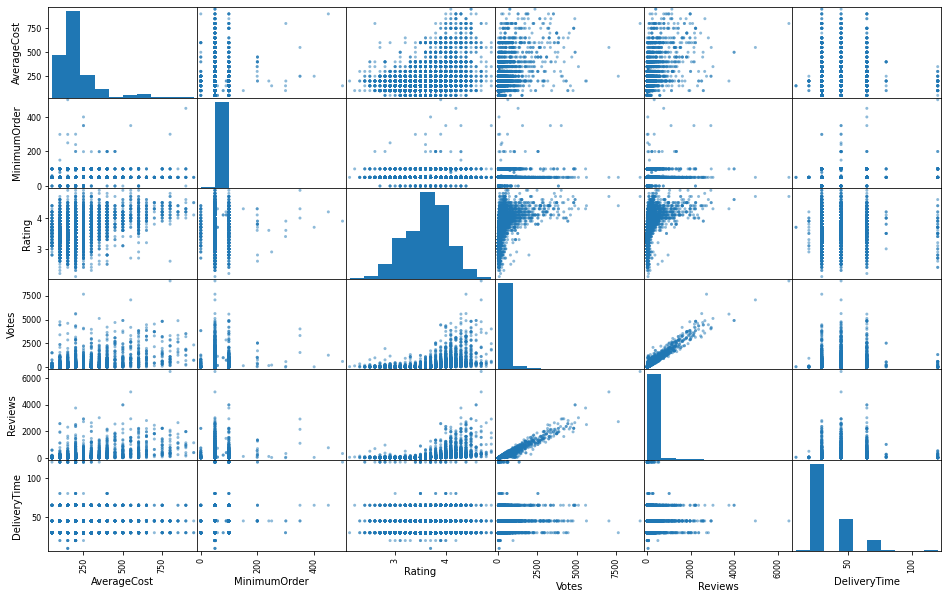

In [15]:
# scatter_matrix 사용해서 상관관계 확인하기

from pandas.plotting import scatter_matrix

scatter_matrix(rest, figsize=(16, 10))
plt.show()

위에서 관찰할 수 있는 사실들?  
- Reviews, Votes는 양의 상관관계  
-  DeliveryTiem의 다른 Feature과의 분포에서 가로 선들이 많이 보인다.$\rightarrow$ 배달의 대략적인 시간들을 구간으로 뭉쳐놨다  
수치형 데이터들과의 명확한 상관관계는 찾기 어렵다.

In [16]:
rest['DeliveryTime'].value_counts()

30     5894
45     2152
65      741
120      52
20       19
80       14
10        3
Name: DeliveryTime, dtype: int64

------

## 4. 머신러닝 알고리즘을 위해 데이터를 준비

#### 학습을 위해 라벨링 칼럼 제외하기

In [17]:
rest = train_set.drop("DeliveryTime", axis=1) # 학습을 위한 배달시간을 제외한 데이터셋
rest_labels = train_set["DeliveryTime"].copy() # 배달시간 
rest.columns

Index(['Restaurant', 'Location', 'Cuisines', 'AverageCost', 'MinimumOrder',
       'Rating', 'Votes', 'Reviews'],
      dtype='object')

### 칼럼 자료형 변환

In [18]:
# Rating 수치형 데이터로 변환
rest['Rating'] = rest['Rating'].apply(pd.to_numeric, errors = 'coerce')
# AverageCost 수치형 데이터로 변환
rest['AverageCost'] =  rest['AverageCost'].apply(pd.to_numeric, errors = 'coerce')
rest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8875 entries, 11025 to 7270
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Restaurant    8875 non-null   object 
 1   Location      8875 non-null   object 
 2   Cuisines      8875 non-null   object 
 3   AverageCost   8851 non-null   float64
 4   MinimumOrder  8875 non-null   int64  
 5   Rating        7326 non-null   float64
 6   Votes         7237 non-null   float64
 7   Reviews       7051 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 624.0+ KB


### 데이터 정제(Data Cleaning)

수치형 데이터의 누락된 값(missing value, 결측값, NaN)을 중간값으로 채움

In [19]:
rest.isnull().any(axis=1)

11025    False
1684     False
499      False
5770     False
8290      True
         ...  
5734     False
5191     False
5390     False
860      False
7270     False
Length: 8875, dtype: bool

In [20]:
sample_incomplete_rows = rest[rest.isnull().any(axis=1)] # 결측치가 있는 값는 모든 행들
sample_incomplete_rows.shape

(1847, 8)

In [21]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# 중간값은 수치형 특성에서만 계산될 수 있기 때문에 텍스트 특성을 제외한 복사본을 생성
obj=["Restaurant", "Location", "Cuisines"]
rest_num = rest.drop(obj, axis=1)
rest_num.head()

,AverageCost,MinimumOrder,Rating,Votes,Reviews
11025,350.0,50,3.8,160.0,73.0
1684,600.0,50,4.0,646.0,370.0
499,200.0,50,3.1,41.0,25.0
5770,100.0,50,4.0,231.0,123.0
8290,150.0,50,NaN,NaN,NaN


In [22]:
imputer.fit(rest_num)

SimpleImputer(strategy='median')

In [23]:
imputer.statistics_ # 객체를 이용한 각각의 수치형 열의 중간값들 

array([200. ,  50. ,   3.6,  63. ,  26. ])

In [24]:
X = imputer.transform(rest_num) # 누락값 -> 중간값, transform할 경우 df -> np.array로 변환되어 리턴된다
X

array([[350. ,  50. ,   3.8, 160. ,  73. ],
       [600. ,  50. ,   4. , 646. , 370. ],
       [200. ,  50. ,   3.1,  41. ,  25. ],
       ...,
       [200. ,  50. ,   3.1,   5. ,   3. ],
       [200. ,  50. ,   3.4,   9. ,   2. ],
       [350. ,  50. ,   4. , 105. ,  71. ]])

In [25]:
# NumPy array -> pandas DataFrame 변환
rest_tr = pd.DataFrame(X, columns=rest_num.columns,
                          index=rest.index)

rest_tr[rest_tr.isnull().any(axis=1)].head() # NaN값 있는지 확인

,AverageCost,MinimumOrder,Rating,Votes,Reviews


In [26]:
sample_incomplete_rows.index.values

array([ 8290, 10394,  2406, ...,  1184,  5051,  5311])

In [27]:
rest_num.loc[sample_incomplete_rows.index.values]  # 결측치 transform 전

,AverageCost,MinimumOrder,Rating,Votes,Reviews
8290,150.0,50,NaN,NaN,NaN
10394,200.0,50,NaN,NaN,NaN
2406,200.0,50,3.0,4.0,NaN
9783,150.0,50,NaN,NaN,NaN
480,100.0,50,NaN,NaN,NaN
...,...,...,...,...,...
1528,150.0,50,NaN,NaN,NaN
8666,200.0,50,NaN,NaN,NaN
1184,50.0,50,NaN,NaN,NaN
5051,100.0,50,NaN,NaN,NaN


In [28]:
rest_tr.loc[sample_incomplete_rows.index.values]  # 결측치 transform 후

,AverageCost,MinimumOrder,Rating,Votes,Reviews
8290,150.0,50.0,3.6,63.0,26.0
10394,200.0,50.0,3.6,63.0,26.0
2406,200.0,50.0,3.0,4.0,26.0
9783,150.0,50.0,3.6,63.0,26.0
480,100.0,50.0,3.6,63.0,26.0
...,...,...,...,...,...
1528,150.0,50.0,3.6,63.0,26.0
8666,200.0,50.0,3.6,63.0,26.0
1184,50.0,50.0,3.6,63.0,26.0
5051,100.0,50.0,3.6,63.0,26.0


### 텍스트와 범주형 특성 다루기

In [29]:
obj=["Restaurant", "Location", "Cuisines"]
#obj=["Location"]
rest_cat = rest[obj]
rest_cat.head(10)

,Restaurant,Location,Cuisines
11025,ID304,"Rmz Centennial, I Gate, Whitefield","North Indian, Andhra, BBQ, Seafood, Chinese"
1684,ID4157,"FTI College, Law College Road, Pune","European, Italian, Continental, Salad, Beverages"
499,ID2772,"Sector 63A,Gurgaon","Chinese, Continental, Italian, Healthy Food, A..."
5770,ID1834,"FTI College, Law College Road, Pune","Bakery, Cafe, Desserts"
8290,ID3496,"Mico Layout, Stage 2, BTM Layout,Bangalore","Chinese, North Indian"
1877,ID5679,Mumbai Central,"Beverages, Fast Food"
3027,ID4895,"Yerawada, Pune, Maharashtra",Fast Food
513,ID3871,Delhi UniversityGTB Nagar,North Indian
6498,ID2372,"FTI College, Law College Road, Pune","North Indian, Chinese, Fast Food, Mughlai"
9063,ID6650,"Rmz Centennial, I Gate, Whitefield",Chinese


#### One-hot encoding

In [30]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False) # sparse = False 값주면 toarray()로 변환하자 않아도 됨
rest_cat_1hot = cat_encoder.fit_transform(rest_cat)
rest_cat_1hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
cat_encoder.categories_

[array(['ID0', 'ID100', 'ID1000', ..., 'ID997', 'ID998', 'ID999'],
       dtype=object),
 array(['BTM Layout 1, Electronic City', 'Babarpur, New Delhi, Delhi',
        'Chandni Chowk, Kolkata', 'Chatta Bazaar, Malakpet, Hyderabad',
        'DBlock, Sector 63, Noida', 'Delhi Administration Flats, Timarpur',
        'Delhi Cantt.', 'Delhi High Court, India Gate',
        'Delhi UniversityGTB Nagar', 'Dockyard Road, Mumbai CST Area',
        'FTI College, Law College Road, Pune',
        'Gora Bazar, Rajbari, North Dumdum, Kolkata',
        'Hyderabad Public School, Begumpet',
        'Jaya Nagar, Saidabad, Hyderabad',
        'Laxman Vihar Industrial Area, Sector 3A, Gurgoan',
        'MG Road, Pune', 'Majestic',
        'Mico Layout, Stage 2, BTM Layout,Bangalore', 'Moulali, Kolkata',
        'Mumbai Central', 'Musi Nagar, Malakpet, Hyderabad',
        'Nathan Road, Mangaldas Road, Pune',
        'Noorkhan Bazaar, Malakpet, Hyderabad',
        'Panjetan Colony, Malakpet, Hyderabad', 'Pu

### 변환 파이프라인(Transformation Pipelines)

**수치형 데이터**

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),  # median값으로 결측치 채우기
        ('std_scaler', StandardScaler()),  # 특성 스케일링 표준화 평균이 0, 분산이 1
    ]) # 위 2가지 작업을 순서대로 해줌

rest_num_tr = num_pipeline.fit_transform(rest_num)
rest_num_tr

array([[ 1.23777301e+00, -1.81559238e-01,  5.00599677e-01,
        -1.01197116e-01, -1.06483115e-01],
       [ 3.30336579e+00, -1.81559238e-01,  1.03203773e+00,
         8.77744345e-01,  9.50211980e-01],
       [-1.58265136e-03, -1.81559238e-01, -1.35943351e+00,
        -3.40896774e-01, -2.77262120e-01],
       ...,
       [-1.58265136e-03, -1.81559238e-01, -1.35943351e+00,
        -4.13410956e-01, -3.55535831e-01],
       [-1.58265136e-03, -1.81559238e-01, -5.62276432e-01,
        -4.05353825e-01, -3.59093727e-01],
       [ 1.23777301e+00, -1.81559238e-01,  1.03203773e+00,
        -2.11982672e-01, -1.13598907e-01]])

**수치형 데이터 & 범주형 데이터**  
칼럼별 변환

In [33]:
from sklearn.compose import ColumnTransformer # 각 col별로 다른 transform을 해줄 수 있다.

num_attribs = list(rest_num)
cat_attribs = ["Restaurant", "Location", "Cuisines"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs), # 수치형 데이터 변환
        ("cat", OneHotEncoder(), cat_attribs), #범주형 데이터 변환
    ])

rest_prepared = full_pipeline.fit_transform(rest)
rest_prepared.shape, rest.shape

((8875, 8304), (8875, 8))

rest_prepared : 준비된 데이터셋

-----

## 5. 모델 선택과 훈련

### 모델 훈련
**선형회귀**

In [34]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(rest_prepared, rest_labels) # 데이터셋, 데이터 목표값

LinearRegression()

In [35]:
lin_reg.coef_ # 각각의 Feature에 해당하는 상관계수 값들 

array([ 0.12746057,  0.70671649,  0.24456128, ..., -1.95998297,
        4.98394893, -1.93686097])

In [36]:
# 각각 상관계수 대수에 따른 Feature 보기

cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(lin_reg.coef_, attributes), reverse=True)

[(145.42087587797695, 'ID4204'),
 (135.65680641856574, 'ID8119'),
 (108.01088321334583, 'ID596'),
 (88.3048487148388, 'ID6882'),
 (87.33817370976698, 'ID829'),
 (87.0405169205729, 'ID1754'),
 (85.93608538360388, 'ID8336'),
 (85.03206681092796, 'ID613'),
 (84.7798854511373, 'ID1342'),
 (84.25007327208786, 'ID1926'),
 (83.9556082722234, 'ID3967'),
 (83.93823893578562, 'ID1384'),
 (82.4909962147097, 'ID7618'),
 (82.15519233097227, 'ID5439'),
 (78.50236089334808, 'ID52'),
 (78.06907281708389, 'ID1434'),
 (77.89502597418935, 'ID1375'),
 (76.91441865884349, 'ID6823'),
 (75.6339563441319, 'ID36'),
 (75.36706899618645, 'ID4599'),
 (75.30071300570066, 'ID6458'),
 (73.79517901001545, 'ID4243'),
 (73.7606710092648, 'ID616'),
 (72.2694266168433, 'ID857'),
 (72.20066918948439, 'ID4447'),
 (72.07859921998941, 'ID5787'),
 (71.85187490011232, 'ID609'),
 (71.65866205923948, 'ID4970'),
 (71.01115305946198, 'ID657'),
 (68.99393380385382, 'ID5934'),
 (67.58117752523255, 'ID2306'),
 (65.81529090708571, 'ID

In [37]:
# 몇 개의 샘플에 대해 데이터변환 및 예측을 해보자
some_data = rest.iloc[:5]
some_labels = rest_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared).round(decimals=1))

Predictions: [45.  45.  39.1 44.2 30. ]


In [38]:
print("Labels:", list(some_labels))

Labels: [45, 45, 45, 45, 30]


### 테스트 데이터 평가지표_1. MAE

In [39]:
from sklearn.metrics import mean_absolute_error

rest_predictions = lin_reg.predict(rest_prepared)
lin_mae = mean_absolute_error(rest_labels, rest_predictions)
lin_mae

0.7630335601685259

에러값이 매우 낮다. -> over-fitting?

#### MSE, RMSE 

In [40]:
import numpy as np
from sklearn.metrics import mean_squared_error

rest_predictions = lin_reg.predict(rest_prepared)
lin_mse = mean_squared_error(rest_labels, rest_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_mse, lin_rmse

(8.238028016489746, 2.8701965118245383)

#### 교차 검증

In [41]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [42]:
lin_scores = cross_val_score(lin_reg, rest_prepared, rest_labels,
                             scoring="neg_mean_absolute_error", cv=10)
lin_mae_scores = np.abs(-lin_scores)
display_scores(lin_mae_scores)

Scores: [7.35378167 7.84079467 7.42788114 8.41760765 7.44831927 7.10371773
 8.05730213 8.81321214 8.34794104 7.83974719]
Mean: 7.865030463108577
Standard deviation: 0.5178327749286853


$\rightarrow$ Mean값을 보니 살짝 오버피팅 되었다.

### 테스트 데이터 평가지표_2. Under-prediction의 비율

- 예측된 배달시간보다 실제 배달시간이 더 걸린 경우(under-prediction)가 반대의 경우(over-prediction)보다 두 배로 사용자의 경험에 안 좋은 영향을 준다고 알려져 있습니다.  
- 가능한 실제 배달시간과 가까운 값을 예측하되 동시에 under-prediction을 최소화하는 것이 좋은 예측모델입니다.  
- Under-prediction의 비율 = under-prediction 개수 / 테스트 데이터의 샘플수

In [43]:
from sklearn.metrics import mean_squared_error

rest_predictions = lin_reg.predict(rest_prepared)
under_predict = len(rest[rest_labels > rest_predictions]) / len(rest_predictions) # 실제 배달시간이 더 걸린 경우
under_predict * 100

51.52676056338028

$\rightarrow$ 비율이 절반 이상으로 높다.

**그럼 모델을 바꿔보자!**  
RandomForestRegressor에 대한 평가

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(rest_prepared, rest_labels)
rest_predictions = forest_reg.predict(rest_prepared)
lin_mae = mean_absolute_error(rest_labels, rest_predictions)
lin_mae  # MAE

1.7220338028169013

In [48]:
# RandomForest 교차검증
foret_scores = cross_val_score(forest_reg, rest_prepared, rest_labels,
                             scoring="neg_mean_absolute_error", cv=10)
forest_mae_scores = np.abs(-lin_scores)
display_scores(forest_mae_scores)

Scores: [4.67443694 4.52567568 4.59408784 4.84206081 4.40686937 4.86071026
 5.07711387 5.52136415 5.2667982  4.45518602]
Mean: 4.822430312217516
Standard deviation: 0.3496213171884236


In [49]:
under_predict = len(rest[rest_labels > rest_predictions]) / len(rest_predictions) # 실제 배달시간이 더 걸린 경우
under_predict * 100 #  Under-prediction의 비율

28.76619718309859

$\rightarrow$ 교차검증결과의 Mean과 Under-prediction의 지표가 일반 선형회귀보다 더 좋아짐. **이 모델로 채택!**

----

## 6. 모델을 상세하게 조정

### 그리드 탐색(Grid Search)

수동으로 하이퍼파라미터 조합을 시도하는 대신 GridSearchCV를 사용하는 것이 좋습니다.

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True)
grid_search.fit(rest_prepared, rest_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [52]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 10}

In [53]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=10,
                      random_state=42)

In [54]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.abs(-mean_score), params)

146.0825508607199 {'max_features': 2, 'n_estimators': 3}
112.22841549295777 {'max_features': 2, 'n_estimators': 10}
102.51110250391234 {'max_features': 2, 'n_estimators': 30}
134.9518935837246 {'max_features': 4, 'n_estimators': 3}
110.03905150905432 {'max_features': 4, 'n_estimators': 10}
102.39401341381623 {'max_features': 4, 'n_estimators': 30}
137.29514866979656 {'max_features': 6, 'n_estimators': 3}
109.92087323943663 {'max_features': 6, 'n_estimators': 10}
102.32909412951537 {'max_features': 6, 'n_estimators': 30}
135.07285089505285 {'max_features': 8, 'n_estimators': 3}
108.39176422643001 {'max_features': 8, 'n_estimators': 10}
100.75988563951168 {'max_features': 8, 'n_estimators': 30}
130.41416275430362 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
102.70327464788734 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
127.55179968701096 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
102.7202806885759 {'bootstrap': False, 'max_features': 3, 'n_es

--------

## 7. 테스트 데이터셋으로 최종 평가

In [95]:
from sklearn.compose import ColumnTransformer # 각 col별로 다른 transform을 해줄 수 있다.

final_model = forest_reg

# X_test = test_set.drop("DeliveryTime", axis=1) # 학습을 위한 배달시간을 제외한 데이터셋
# y_test = test_set["DeliveryTime"].copy() # 배달시간

# 칼럼 자료형 변환
X_test['Rating'] = X_test['Rating'].apply(pd.to_numeric, errors = 'coerce')
X_test['AverageCost'] =  X_test['AverageCost'].apply(pd.to_numeric, errors = 'coerce')

# X_test_prepared = full_pipeline.fit_transform(X_test)
# final_predictions = final_model.predict(X_test_prepared)

# final_mae = mean_absolute_error(y_test, final_predictions)
# final_mae  # MAE

final_model = grid_search.best_estimator_ # 최종 모델 

X_test = test_set.drop("DeliveryTime", axis=1) # 학습을 위한 배달시간을 제외한 데이터셋
y_test = test_set["DeliveryTime"].copy() # 배달시간

X_test_prepared = full_pipeline.transform(X_test)  # Error 
final_predictions = final_model.predict(X_test_prepared)

final_mae = mean_absolute_error(y_test, final_predictions)
final_mae  # MAE

2.019580892293826

In [96]:
final_under_predict = len(X_test[y_test > final_predictions]) / len(final_predictions) # 실제 배달시간이 더 걸린 경우
final_under_predict * 100 #  Under-prediction의 비율

27.35466426318161

모델 세부조정에 있어 새로운 데이터를 학습하는데에 찾지 못하는 오류가 있어서 조정 전 RandomForest로 학습시켰습니다.